In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wise_tools as wtl
import PYCCF as myccf
from matplotlib.pyplot import MultipleLocator
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import rcParams
import csv
from astropy.timeseries import LombScargle
import celerite
from celerite import terms
from scipy.optimize import minimize
import emcee
import numpy as np
import wise_tools as wtl
import matplotlib.pyplot as plt
import matplotlib
matplotlib.interactive('True')
import scienceplots
plt.style.use(['nature', 'science'])
import PYCCF
import wise_tools as wtl # for rebining the data
from tqdm import tqdm

%matplotlib notebook
config = {
            "font.family": 'serif',
            "font.size": 15,
            "mathtext.fontset": 'stix',
            "font.serif": ['Times New Roman'],
         }
rcParams.update(config)

In [2]:
# Load synthetic_V band light curve
LC_synthetic_V = np.genfromtxt("PKS_J2134-0153_synthetic_V.csv", delimiter=',', names=True)
t_V = LC_synthetic_V["mjd"]
mag_V = LC_synthetic_V["mag"]
mag_err_V = LC_synthetic_V["magerr"]

# reject a few outliers
sel_noout = np.where((mag_V<=20.)&(mag_err_V>0.0), True, False)
t_V = t_V[sel_noout]
mag_V = mag_V[sel_noout]
mag_err_V = mag_err_V[sel_noout]

#Binned the light curve by 180 days
rebin_V = wtl.rebin(t=t_V, x=mag_V,xe =mag_err_V, tduration=180)

In [3]:
#Load radio band light curve
radio = pd.read_csv('J2134-0153_radio.csv')

t_radio_unbin = np.array(radio['mjd'])
radio_mag_unbin = -2.5*np.log10(np.array(radio['flux'])/np.mean(np.array(radio['flux'])))+18.
radio_mag_err_unbin = np.array(radio['flux_err'])/np.array(radio['flux'])*2.5/np.log(10.)


#Binned the light curve by 180 days
rebin_radio = wtl.rebin(t=t_radio_unbin, x=radio_mag_unbin,xe =radio_mag_err_unbin, tduration=180)

t_radio = rebin_radio[0]
radio_mag = rebin_radio[1]
radio_mag_err = rebin_radio[2]




In [4]:
#Load IR band lighe curves


#Load the ALL WISE data
NEO_WISE = pd.read_csv('J2134-0153_NEOWISE.csv')
t_NEOWISE = NEO_WISE['mjd']
W1_NEOWISE = NEO_WISE['w1mpro']
W1err_NEOWISE = NEO_WISE['w1sigmpro']
W2_NEOWISE = NEO_WISE['w2mpro']
W2err_NEOWISE = NEO_WISE['w2sigmpro']


#remove the bad data
sel_NEOWISE = np.where((NEO_WISE['qi_fact']>=1) & (NEO_WISE['moon_masked']<=0)&(NEO_WISE['saa_sep']>=5), True, False)
t_NEOWISE = t_NEOWISE[sel_NEOWISE]
W1_NEOWISE = W1_NEOWISE[sel_NEOWISE]
W1err_NEOWISE = W1err_NEOWISE[sel_NEOWISE]
W2_NEOWISE = W2_NEOWISE[sel_NEOWISE]
W2err_NEOWISE = W2err_NEOWISE[sel_NEOWISE]





#Load the NEO WISE data
WISE = pd.read_csv('J2134-0153_WISE.csv')
t_WISE = WISE['mjd']
W1_WISE = WISE['w1mpro_ep']
W1err_WISE = WISE['w1sigmpro_ep']
W2_WISE = WISE['w2mpro_ep']
W2err_WISE = WISE['w2sigmpro_ep']


#remove the bad data
sel_WISE = np.where((WISE['qi_fact']>=1) & (WISE['moon_masked']<=0)&(WISE['saa_sep']>=5), True, False)
t_WISE = t_WISE[sel_WISE]
W1_WISE = W1_WISE[sel_WISE]
W1err_WISE = W1err_WISE[sel_WISE]
W2_WISE = W2_WISE[sel_WISE]
W2err_WISE = W2err_WISE[sel_WISE]



#Merge these light curves
t_wise_all = np.append(t_NEOWISE,t_WISE)
W1_all = np.append(W1_NEOWISE,W1_WISE)
W1err_all = np.append(W1err_NEOWISE,W1err_WISE)
W2_all = np.append(W2_NEOWISE,W2_WISE)
W2err_all = np.append(W2err_NEOWISE,W2err_WISE)


#Make sure the time for light curves are increased
seq_WISE_all = np.argsort(t_wise_all)
t_WISE_seq = np.array(t_wise_all[seq_WISE_all])
W1_mag_seq = np.array(W1_all[seq_WISE_all])
W1_mag_err_seq = np.array(W1err_all[seq_WISE_all])
W2_mag_seq = np.array(W2_all[seq_WISE_all])
W2_mag_err_seq = np.array(W2err_all[seq_WISE_all])



#Binned these light curves by 180 days
rebin_W1 = wtl.rebin(t=t_WISE_seq, x=W1_mag_seq,xe =W1_mag_err_seq, tduration=180)
rebin_W2 = wtl.rebin(t=t_WISE_seq, x=W2_mag_seq,xe =W2_mag_err_seq, tduration=180)

t_IR = rebin_W1[0]
W1 = rebin_W1[1]
W1err = rebin_W1[2]
W2 = rebin_W2[1]
W2err = rebin_W2[2]


In [5]:
# time lag: synthetic_V-radio
lag_range = [-4000, 4000]  #Time lag range to consider in the CCF (days). Must be small enough that there is some overlap between light curves at that shift (i.e., if the light curves span 80 days, these values must be less than 80 days)
interp = 60 #Interpolation time step (days). Must be less than the average cadence of the observations, but too small will introduce noise.
nsim = 500  #Number of Monte Carlo iterations for calculation of uncertainties
mcmode = 0  #Do both FR/RSS sampling (1 = RSS only, 2 = FR only) 
sigmode = 0.2  #Choose the threshold for considering a measurement "significant". sigmode = 0.2 will consider all CCFs with r_max <= 0.2 as "failed". See code for different sigmodes.


tlag_peak_V_radio, status_peak_V_radio, tlag_centroid_V_radio, status_centroid_V_radio, ccf_pack_V_radio, max_rval_V_radio, status_rval_V_radio, pval_V_radio = myccf.peakcent(rebin_V[0],rebin_V[1], t_radio, radio_mag, lag_range[0], lag_range[1],tunit=interp, imode=1 )



In [6]:
#time lag: IR-radio
lag_range = [-4000, 4000]  #Time lag range to consider in the CCF (days). Must be small enough that there is some overlap between light curves at that shift (i.e., if the light curves span 80 days, these values must be less than 80 days)
interp = 60 #Interpolation time step (days). Must be less than the average cadence of the observations, but too small will introduce noise.
nsim = 500  #Number of Monte Carlo iterations for calculation of uncertainties
mcmode = 0  #Do both FR/RSS sampling (1 = RSS only, 2 = FR only) 
sigmode = 0.2  #Choose the threshold for considering a measurement "significant". sigmode = 0.2 will consider all CCFs with r_max <= 0.2 as "failed". See code for different sigmodes.


tlag_peak_IR_radio, status_peak_IR_radio, tlag_centroid_IR_radio, status_centroid_IR_radio, ccf_pack_IR_radio, max_rval_IR_radio, status_rval_IR_radio, pval_IR_radio = myccf.peakcent(t_IR,W1, t_radio, radio_mag, lag_range[0], lag_range[1],tunit=interp, imode=1 )

In [7]:
#time lag: mocked_V-real radio
from tqdm import tqdm
import PYCCF
# optical DRW
optical_lc = np.load('2134-0153(V_unbin)_simulation.npz')
optical_t = optical_lc['t']
optical_m = optical_lc['xflux_sim']
optical_e = optical_lc['xerror']

timelag_mocked_V_radio = []
rho_mocked_V_radio = []
pvals_mocked_V_radio = []

lag_range = [-4000, 4000]  #Time lag range to consider in the CCF (days). Must be small enough that there is some overlap between light curves at that shift (i.e., if the light curves span 80 days, these values must be less than 80 days)
interp = 60 #Interpolation time step (days). Must be less than the average cadence of the observations, but too small will introduce noise.
nsim = 500  #Number of Monte Carlo iterations for calculation of uncertainties
mcmode = 0  #Do both FR/RSS sampling (1 = RSS only, 2 = FR only) 
sigmode = 0.2  #Choose the threshold for considering a measurement "significant". sigmode = 0.2 will consider all CCFs with r_max <= 0.2 as "failed". See code for different sigmodes.

for i in tqdm(range(20000)):
    rebin_V_sim = wtl.rebin(t=optical_t, x=optical_m[:,i],xe =optical_e[:,i], tduration=180)
    
    tlag_peak_mocked_V_radio, status_peak_mocked_V_radio, tlag_centroid_mocked_V_radio, status_centroid_mocked_V_radio, ccf_pack_mocked_V_radio, max_rval_mocked_V_radio, status_rval_mocked_V_radio, pval_mocked_V_radio = myccf.peakcent(rebin_V_sim[0],rebin_V_sim[1], t_radio, radio_mag, lag_range[0], lag_range[1],tunit=interp, imode=1 )
    timelag_mocked_V_radio.append(ccf_pack_mocked_V_radio[1])
    rho_mocked_V_radio.append(ccf_pack_mocked_V_radio[0]*((ccf_pack_mocked_V_radio[2]/len(t_radio))**2))
    pvals_mocked_V_radio.append(pval_mocked_V_radio)
    
    

100%|████████████████████████████████████| 20000/20000 [03:01<00:00, 110.00it/s]


<IPython.core.display.Javascript object>


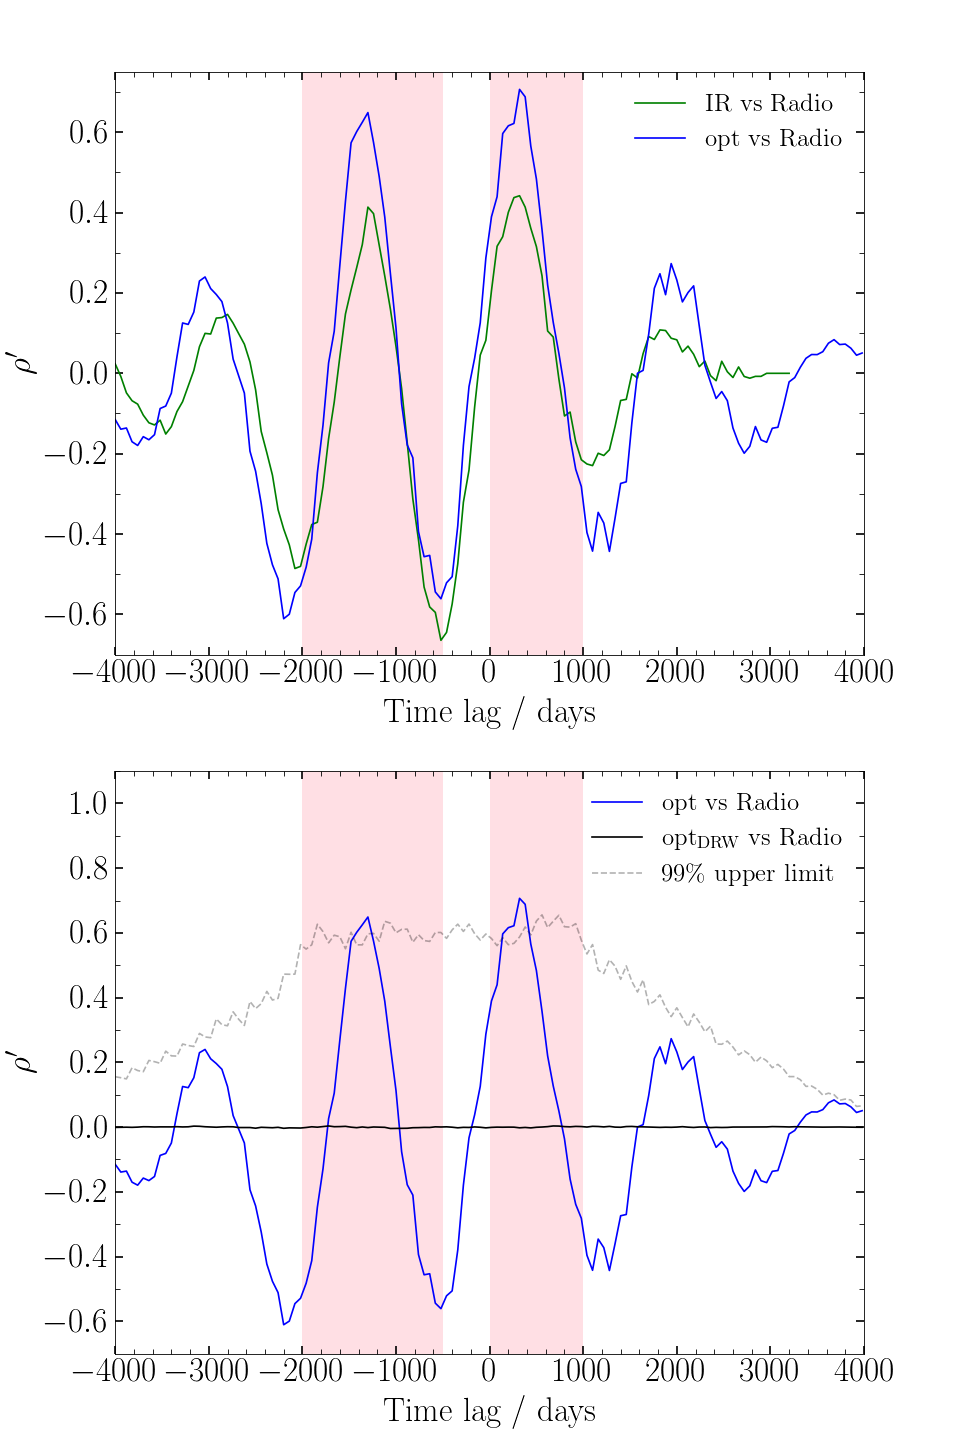

In [8]:
#Make time lag plot
fig = plt.figure(figsize=(8, 12))
plt.subplots_adjust(left=0.12, right=0.9, top=0.95, bottom=0.06)

plt.subplot(2,1,1)


plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.xlim(-4000,4000)

plt.plot(ccf_pack_IR_radio[1],ccf_pack_IR_radio[0]*((ccf_pack_IR_radio[2]/len(t_radio))**2),'-',c = 'g')


plt.plot(ccf_pack_V_radio[1],ccf_pack_V_radio[0]*((ccf_pack_V_radio[2]/len(t_radio))**2),'-',c = 'b')
plt.xlabel('Time lag / days',fontsize=20)
plt.ylabel("$\\rho'$",fontsize=20)
plt.gca().xaxis.set_major_locator(MultipleLocator(1000))
plt.gca().yaxis.set_major_locator(MultipleLocator(0.2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().tick_params(axis='both',labelsize=20)
plt.tick_params(top='on', right='on', which='major',length=5, width = 1)
plt.tick_params(top='on', right='on', which='minor',length=3)

plt.ylim(-0.7,0.75)
plt.legend(["IR vs Radio","opt vs Radio"],loc='upper right',fontsize=15)




plt.tick_params(bottom=True, top=True, left=True, right=True)



plt.fill_between([0,1000],-0.7,0.75,facecolor = 'pink', alpha = 0.5)
plt.fill_between([-2000,-500],-0.7,0.75,facecolor = 'pink', alpha = 0.5)



plt.subplot(2,1,2)

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.xlim(-4000,4000)


rho_mocked_V_radio_median = np.median(np.array(rho_mocked_V_radio),axis = 0)  # median rho between mocked V band light curves and radio light curve

rho_mocked_V_radio_median_3sigma = np.percentile(np.array(rho_mocked_V_radio),99,axis = 0) # 99% upper limit of rho



plt.plot(ccf_pack_V_radio[1],ccf_pack_V_radio[0]*((ccf_pack_V_radio[2]/len(t_radio))**2),'-',c = 'b')

plt.plot(timelag_mocked_V_radio[0],rho_mocked_V_radio_median,'-',c = 'black',alpha = 1)


plt.plot(timelag_mocked_V_radio[0],rho_mocked_V_radio_median_3sigma,'--',c = 'black',alpha = 0.3)


plt.xlabel('Time lag / days',fontsize=20)
plt.ylabel("$\\rho'$",fontsize=20)
plt.gca().xaxis.set_major_locator(MultipleLocator(1000))
plt.gca().yaxis.set_major_locator(MultipleLocator(0.2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().tick_params(axis='both',labelsize=20)
plt.tick_params(top='on', right='on', which='major',length=5, width = 1)
plt.tick_params(top='on', right='on', which='minor',length=3)

plt.ylim(-0.7,1.1)
plt.legend(["opt vs Radio", r"$\mathrm{opt_{DRW}}$ vs Radio",r"$99\%$ upper limit"],loc= 'upper right',fontsize=15)




plt.tick_params(bottom=True, top=True, left=True, right=True)



plt.fill_between([0,1000],-0.7,1.1,facecolor = 'pink', alpha = 0.5)
plt.fill_between([-2000,-500],-0.7,1.1,facecolor = 'pink', alpha = 0.5)

#plt.savefig('fig4.pdf', dpi = 300)

In [9]:
# CCF between optical DRW and radio real
rmax_all = np.zeros((20000,))
p_rmax_all = np.zeros((20000,))

for i in tqdm(range(20000)):
    optical_t_seg = optical_t
    optical_m_seg = optical_m[:, i]
    optical_e_seg = optical_e[:, i]
    optical_rebin = wtl.rebin(optical_t_seg, optical_m_seg, optical_e_seg)
    ccf_OR = PYCCF.peakcent(t_radio, radio_mag, optical_rebin[0], optical_rebin[1], -4000., 4000., 60., imode=0)
    ccf_selmax = np.argmax(ccf_OR[-4][0])
    rmax_all[i] = ccf_OR[-3] * np.exp(-(ccf_OR[-4][2][ccf_selmax]/np.max(ccf_OR[-4][2]))**2.)
    p_rmax_all[i] = ccf_OR[-1]


100%|█████████████████████████████████████| 20000/20000 [04:56<00:00, 67.37it/s]


<IPython.core.display.Javascript object>


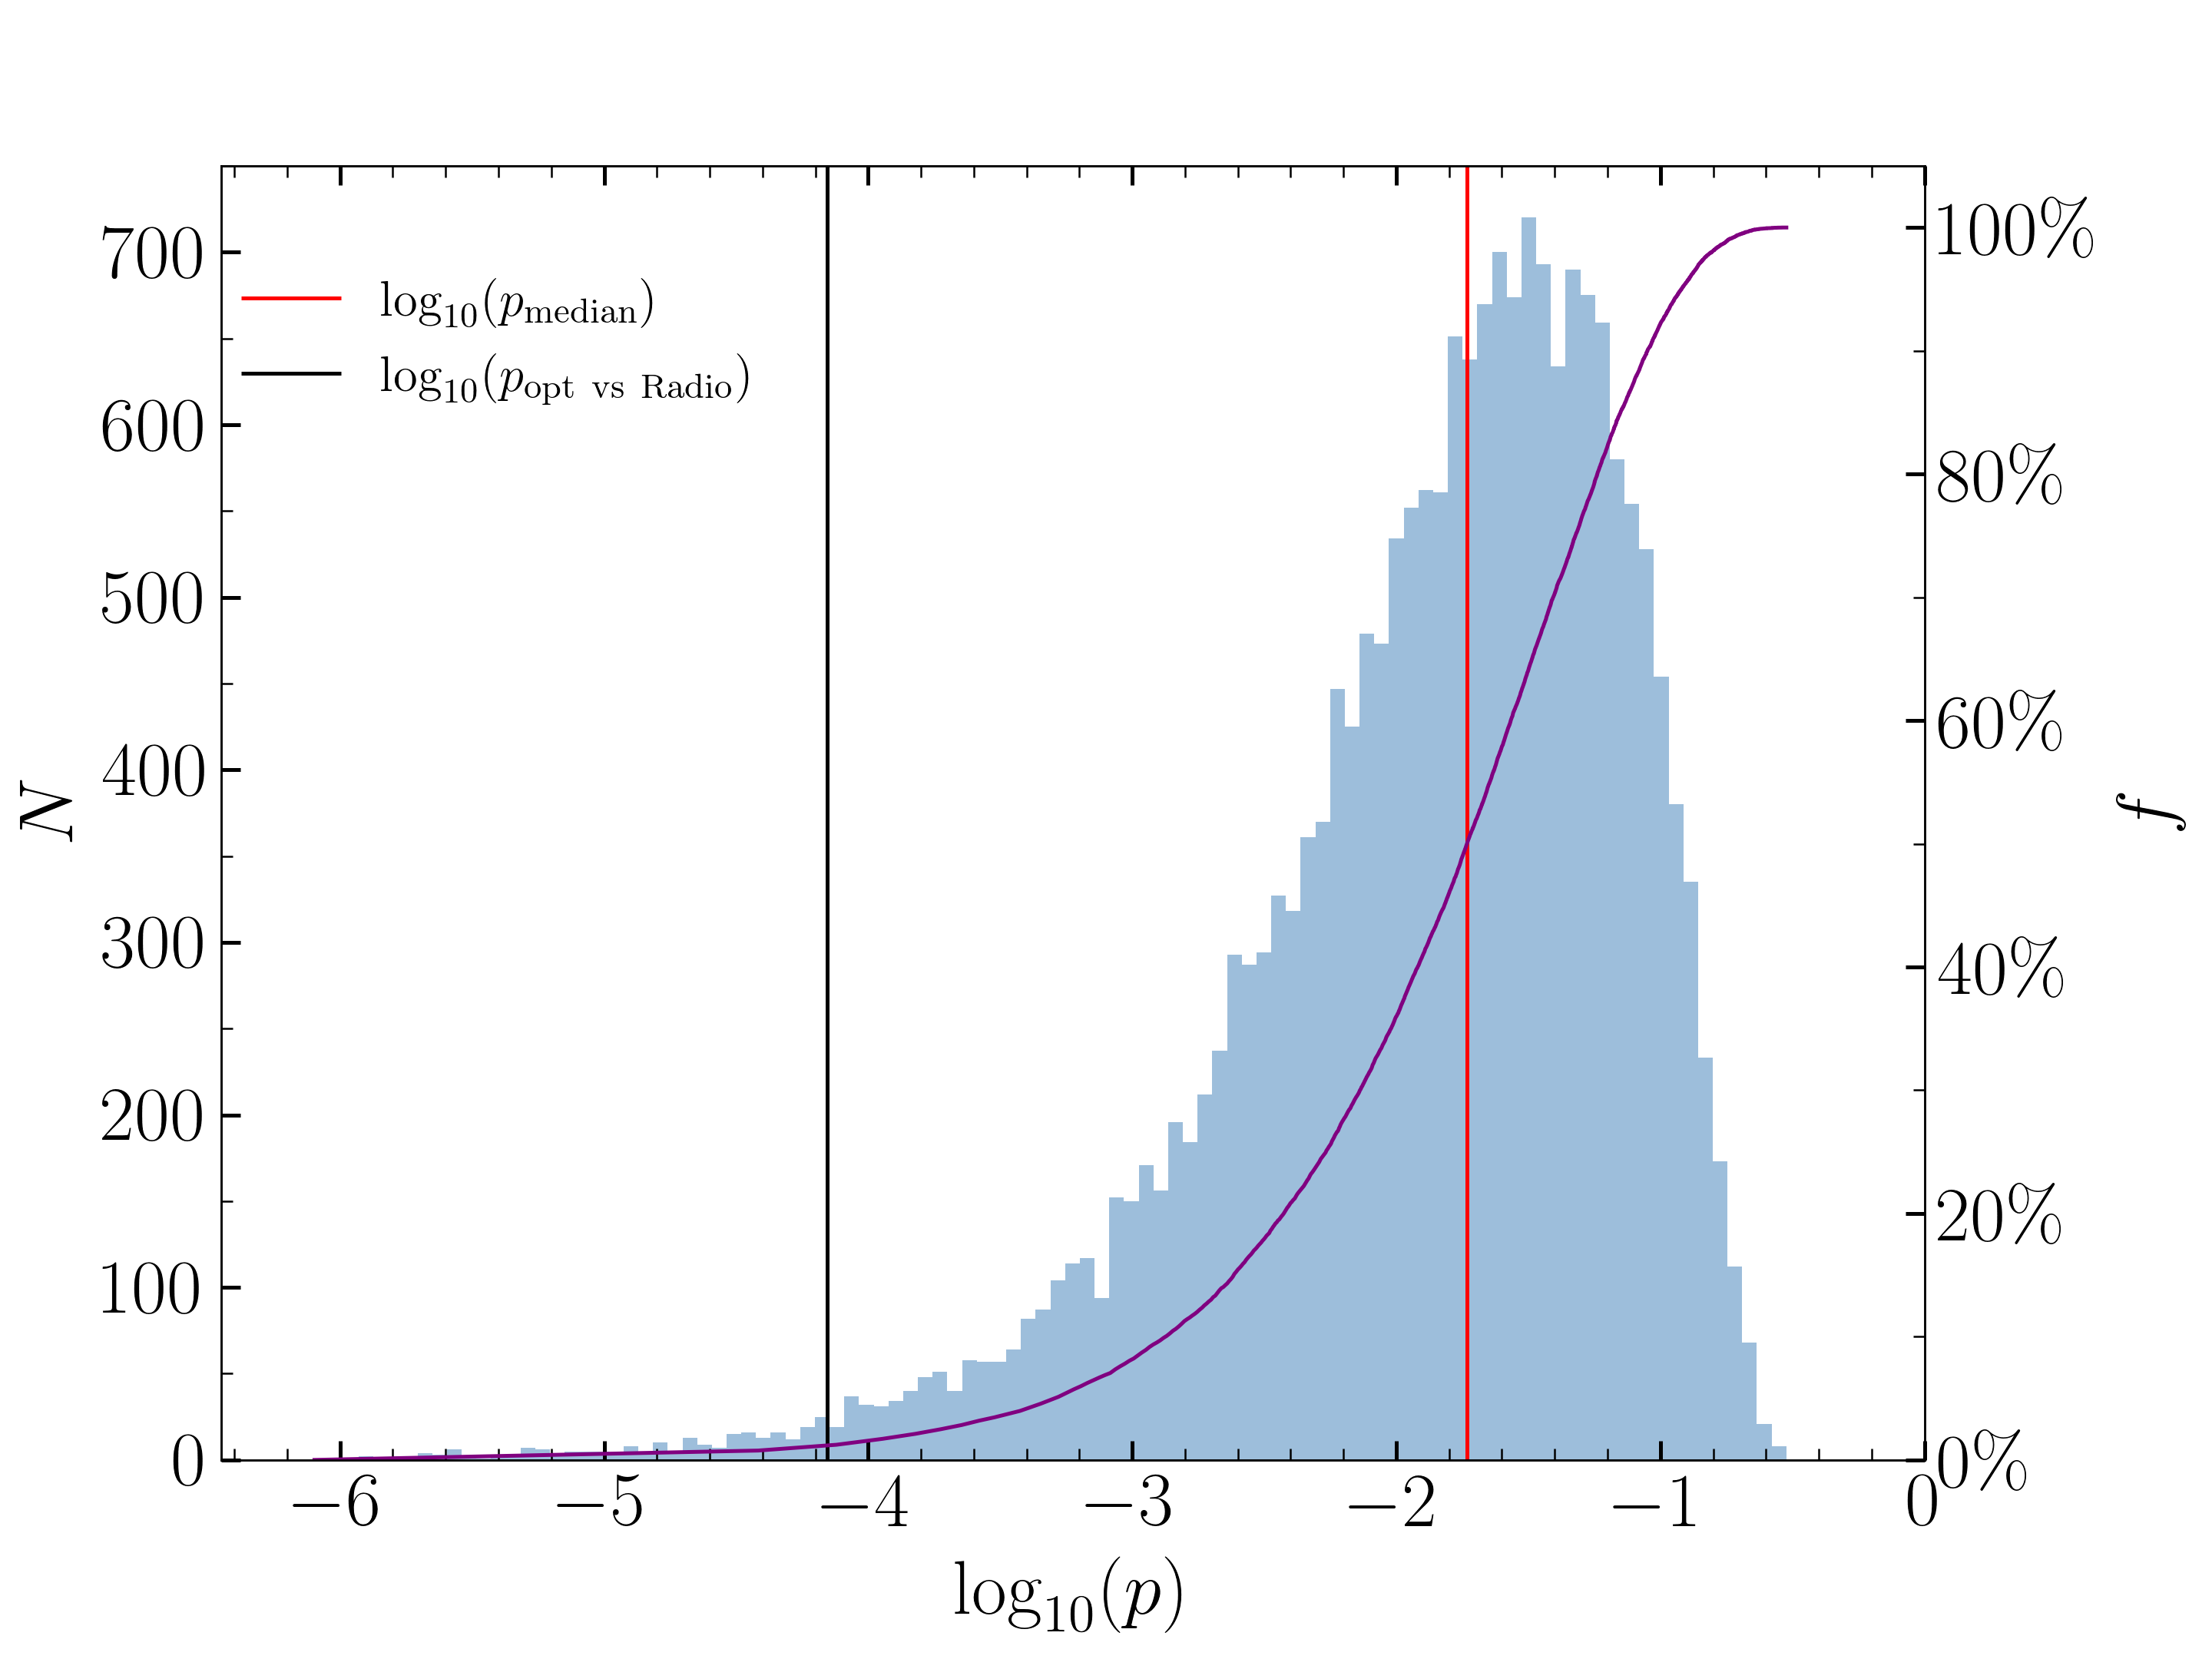

In [10]:



from matplotlib.ticker import FuncFormatter

fig= plt.figure(figsize=(8, 6),dpi=300)
plt.subplots_adjust(left=0.1, right=0.87, top=0.9, bottom=0.12)

ax1 = fig.add_subplot(111)


ax1.hist(np.log10(p_rmax_all),bins=100,range = [np.log10(0.0000008),np.log10(0.3)],cumulative=False,density=False,alpha = 0.4)



plt.vlines(x = np.log10(np.median(p_rmax_all)),ymin = 0,ymax = 1600,color = 'r')
plt.vlines(x = np.log10(6.e-6),ymin = 0,ymax = 1600,color = 'black')



plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(100))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().tick_params(axis='both',labelsize=20)
plt.tick_params(top='on', right='on', which='major',length=5, width = 1)
plt.tick_params(top='on', right='on', which='minor',length=3)

plt.ylim(0,750)
plt.legend([ "$\log_{10}(p_{\mathrm{median}})$", "$\log_{10}(p_{\mathrm{opt\ vs\ Radio}})$"],loc= [0,0.8],fontsize=13)

plt.xlabel(r"$\log_{10}(p)$",fontsize=20)
plt.ylabel("$N$",fontsize=20)


ax2=ax1.twinx()

rho_percent,rho,c = plt.hist(p_rmax_all,bins=8000,range = [0.0000008,0.3],cumulative=True,density=True)

plt.plot(np.log10(rho),np.concatenate(([0],rho_percent)),color = 'purple')


plt.gca().yaxis.set_major_locator(MultipleLocator(0.2))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.tick_params(top='on', right='on', which='major',length=5, width = 1)
plt.tick_params(top='on', right='on', which='minor',length=3)
plt.ylabel("$f$",fontsize=20)
plt.xlim(-6.45,0)
plt.ylim(0,1.05)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1],['$0\%$', '$20\%$', '$40\%$', '$60\%$', '$80\%$', '$100\%$'],fontsize=20)


#plt.savefig('fig5.pdf', dpi = 300)   

In [11]:
# time lag: synthetic_V-IR
lag_range = [-4000, 4000]  #Time lag range to consider in the CCF (days). Must be small enough that there is some overlap between light curves at that shift (i.e., if the light curves span 80 days, these values must be less than 80 days)
interp = 60 #Interpolation time step (days). Must be less than the average cadence of the observations, but too small will introduce noise.
nsim = 500  #Number of Monte Carlo iterations for calculation of uncertainties
mcmode = 0  #Do both FR/RSS sampling (1 = RSS only, 2 = FR only) 
sigmode = 0.2  #Choose the threshold for considering a measurement "significant". sigmode = 0.2 will consider all CCFs with r_max <= 0.2 as "failed". See code for different sigmodes.


tlag_peak_V_IR, status_peak_V_IR, tlag_centroid_V_IR, status_centroid_V_IR, ccf_pack_V_IR, max_rval_V_IR, status_rval_V_IR, pval_V_IR = myccf.peakcent(rebin_V[0],rebin_V[1], t_IR, W1, lag_range[0], lag_range[1],tunit=interp, imode=1 )

<IPython.core.display.Javascript object>


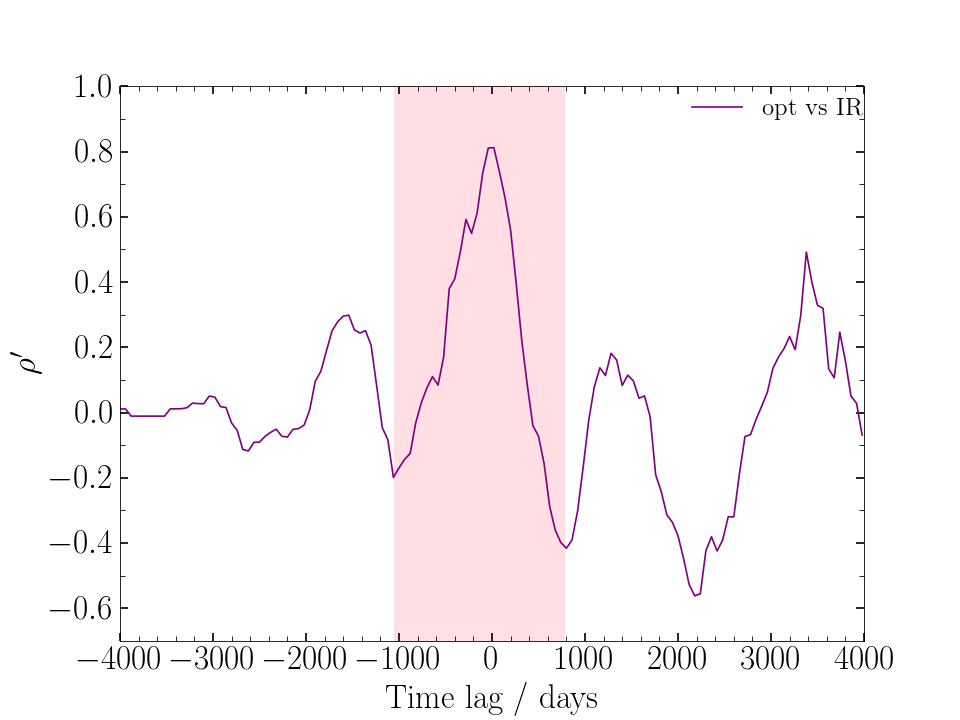

In [13]:
#Make time lag plot
fig = plt.figure(figsize=(8,6))

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.xlim(-4000,4000)

#plt.plot(ccf_pack_IR_radio[1],ccf_pack_IR_radio[0]*((ccf_pack_IR_radio[2]/len(t_radio))**2),'-',c = 'g')


plt.plot(ccf_pack_V_IR[1],ccf_pack_V_IR[0]*((ccf_pack_V_IR[2]/len(t_IR))**2),'-',c = 'purple')
plt.xlabel('Time lag / days',fontsize=20)
plt.ylabel("$\\rho'$",fontsize=20)
plt.gca().xaxis.set_major_locator(MultipleLocator(1000))
plt.gca().yaxis.set_major_locator(MultipleLocator(0.2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().tick_params(axis='both',labelsize=20)
plt.tick_params(top='on', right='on', which='major',length=5, width = 1)
plt.tick_params(top='on', right='on', which='minor',length=3)

plt.ylim(-0.7,1)
plt.legend(["opt vs IR"],loc=(0.755,0.92),fontsize=15)




plt.tick_params(bottom=True, top=True, left=True, right=True)



plt.fill_between([-1050,790],-0.7,1,facecolor = 'pink', alpha = 0.5)

#plt.savefig('fig6.pdf', dpi = 300)